The workflow for interrogating data for the presence of clusters is as follows:
 - Import the data into a Pandas dataframe
 - Format the data to contain just numerical columns for linkage matrix
 - Create the linkage matrix using scipy and an appropriate HAC algorithm: Ward, complete, single, etc.
 - Visually inspect the dendrogram to identify the best point to cut off the tree
 - Run the PCP function to test the fit of the clustering algorithm at the chosen distance

In [1]:
import pandas as pd
import scipy as sp
import bokeh
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from bokeh.io import output_notebook
from matplotlib import pyplot as plt
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.models.mappers import CategoricalColorMapper

In [2]:
%autosave 0
%matplotlib inline
output_notebook()

Autosave disabled


Loading BokehJS ...

In [3]:
orig_df = pd.read_csv('iris.csv')
num_df = orig_df.select_dtypes(exclude='object')

In [4]:
Z = linkage(num_df, 'ward')

In [5]:
#adapted from https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

def fancy_dendrogram(*args, **kwargs):
    """
    Function to draw the dendrogram .svg
    
    The two extra arguments that enhance the default dendrogram are:
        max_d - the point y at which to draw a horizontal guideline
        annotate_above - the minimum distance y for which to show annotations 
    """
    Z = args[0]
    max_d = kwargs.pop('max_d', None) 
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', None)
    
    plt.figure(dpi=400, figsize=(12,6)) #make sure DPI is decent
    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            
            if annotate_above != None:
                if y > annotate_above:                
                    #draw annotation points and annotations
                    plt.plot(x, y, 'ob') #ob is blue circle
                    plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                                textcoords='offset points',
                                va='top', ha='center',
                                color='black')
        if max_d:
            #draw the horizontal line with annotations
            plt.axhline(y=max_d, c='black', ls='dashed', alpha=1, aa=True,lw=0.5)
            num_clusters = fcluster(Z, max_d, criterion='distance').max()
            plt.annotate("Number of clusters at distance {} is: {}".format(max_d, num_clusters),
                        xy=(0,max_d+(max_d*0.1)), va='bottom', rotation=-90)
    return ddata

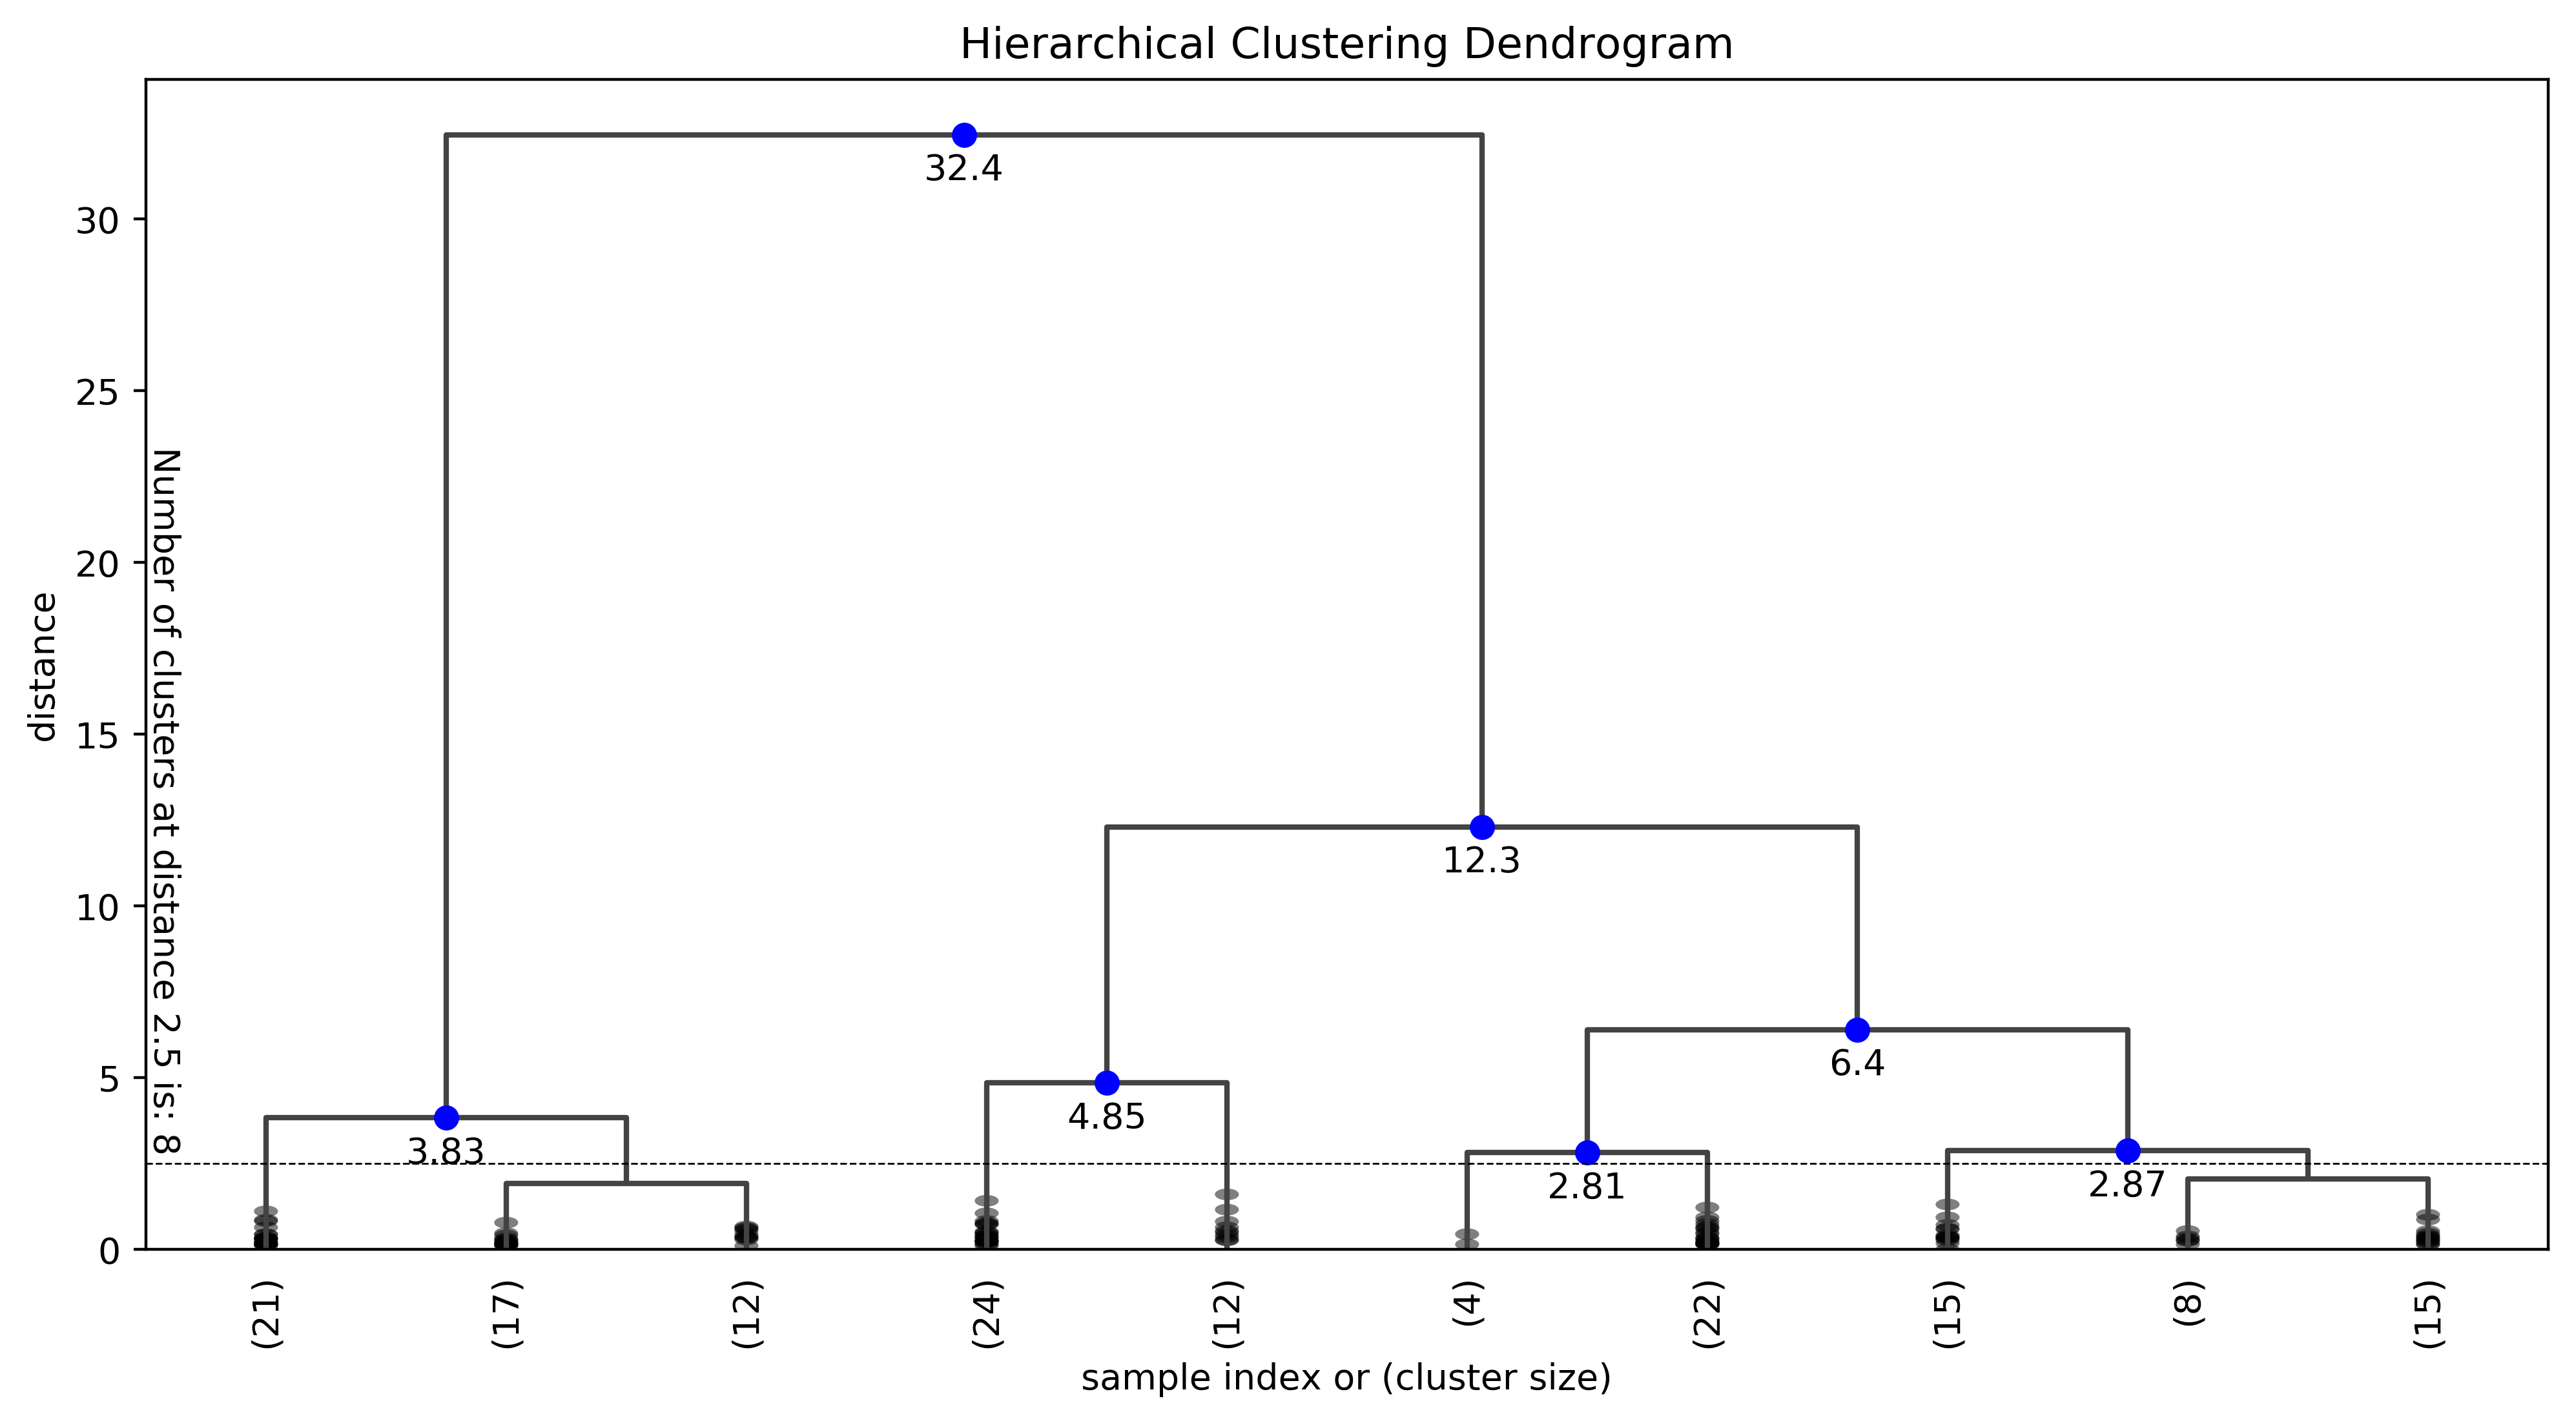

In [6]:
#inspect the dendrogram visually first, then uncomment the parameters to give more nuance

fancy_dendrogram(
    Z,
    leaf_rotation=90.,
    leaf_font_size=10.,
    link_color_func=lambda x:'#434344',
    color_threshold=0,
    show_contracted=True,
    truncate_mode='lastp',
    p=10,
    annotate_above=2.5,
    max_d=2.5,
)
plt.show()

In [7]:
def pcp(df, Z, max_d, norm, **kwargs):
    """
    Parallel Coordinates Plot to visualise clusters within original dataset
    
    You need to provide the constructor with a few things:
        - df is the dataframe that you used for creating the linkage matrix
        - Z is the linkage matrix
        - max_d is the distance at which to cut the HAC dendrogram
        - norm is whether to use Normalize function or not: True/False
        
    By default, the axes for the PCP will be taken from the column headers in DF;
    You can overwrite them by adding in an optional parameter 'domains=[]'. The 
    number of user-set domains must match the number of columns used to create the
    linkage matrix.
    """
    df = df.copy()
    
    if 'domains' not in kwargs:
        domains = df.columns.values
    else:
        if (len(kwargs['domains']) == len(df.columns.values)):
            domains = kwargs['domains']
        else:
            raise ValueError("The number of domains doesn't match original DF")
    
    num_aliases = list(range(len(domains)))
    
    def normalize(df):
        result = df.copy()
        for feature_name in df.columns:
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
        return result
    
    if norm:
        df = normalize(df)
        
    #add clusters and colours to the df
    #full list of palettes: https://bokeh.pydata.org/en/latest/docs/reference/palettes.html

    df['clusters'] = fcluster(Z, max_d, criterion='distance')
    
    palette = bokeh.palettes.brewer['Set1'][df['clusters'].max()]
    cl = list(df['clusters'].unique())
    color_dict = dict(zip(cl,palette))    
    
    df['color'] = [color_dict.get(v, None) for v in df['clusters']]
    
    #multiline doesn't work with a categorical x-axis so we need to alias x-axis values.
    #y_range bounds depend on whether the dataset was normalised or not - TO DO
    p = figure(plot_width=800, plot_height=400, x_range=(0,len(domains)-1), y_range=(0,1))

    p.title.text = 'Parallel coordinates plot in Bokeh'
    p.title.align = 'center'

    #format x and y axis, including overwriting labels
    p.xaxis.ticker = num_aliases
    p.xaxis.major_label_overrides = dict(zip(num_aliases, domains))
    p.yaxis.axis_label = "Y-Axis"
    p.yaxis.minor_tick_line_color = None
    
    #create renderers: segment for PCP "axis" and multi-line for actual lines
    p.segment(x0=num_aliases, y0=[0]*len(domains), x1=num_aliases,
              y1=[1]*len(domains), color="grey", line_width=2)

    p.multi_line(xs=[num_aliases]*len(df), ys=[list(row.values) for index, row in df.iterrows()],
                 line_width=1, line_alpha=0.4, line_color=df['color'])

    p.grid.visible = False

    return p

In [8]:
p = pcp(num_df, Z, 10, norm=True)
show(p)